In [39]:
!pip install torch torchvision matplotlib

In [40]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define image transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Paths to folders
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Load the data
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Class names
print("Classes:", train_data.classes)


Classes: ['bad', 'good']


In [41]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze the base layers (optional, helps if dataset is small)
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head
model.classifier[1] = nn.Linear(model.last_channel, 1)  # 1 output node for binary classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


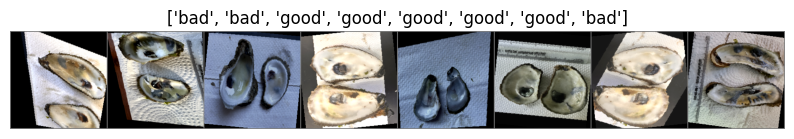

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to unnormalize and display an image
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize from [-1,1] to [0,1]
    npimg = img.numpy()
    plt.figure(figsize=(10, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show a grid of 8 images
classes = train_data.classes  # ['bad', 'good']
imshow(torchvision.utils.make_grid(images[:8]), title=[classes[label] for label in labels[:8]])


In [43]:
from collections import Counter
import os

def count_images(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images
    return class_counts

# Paths
train_counts = count_images('dataset/train')
test_counts = count_images('dataset/test')

# Print results
print("Training Set Counts:")
for label, count in train_counts.items():
    print(f"  {label}: {count} images")

print("\nTesting Set Counts:")
for label, count in test_counts.items():
    print(f"  {label}: {count} images")


Training Set Counts:
  bad: 53 images
  good: 97 images

Testing Set Counts:
  bad: 38 images
  good: 37 images


In [44]:
import torch.optim as optim

# Handle class imbalance
pos_weight = torch.tensor([97 / 53]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Only train classifier layer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [45]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")


Epoch 1/10, Loss: 8.9879, Accuracy: 62.67%
Epoch 2/10, Loss: 7.3584, Accuracy: 64.67%
Epoch 3/10, Loss: 6.8704, Accuracy: 70.00%
Epoch 4/10, Loss: 6.5074, Accuracy: 66.67%
Epoch 5/10, Loss: 5.8751, Accuracy: 86.67%
Epoch 6/10, Loss: 5.5590, Accuracy: 75.33%
Epoch 7/10, Loss: 4.8444, Accuracy: 84.00%
Epoch 8/10, Loss: 4.4995, Accuracy: 81.33%
Epoch 9/10, Loss: 4.0582, Accuracy: 87.33%
Epoch 10/10, Loss: 4.0391, Accuracy: 88.67%


In [46]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"🧪 Test Accuracy: {test_acc:.2f}%")


🧪 Test Accuracy: 77.33%


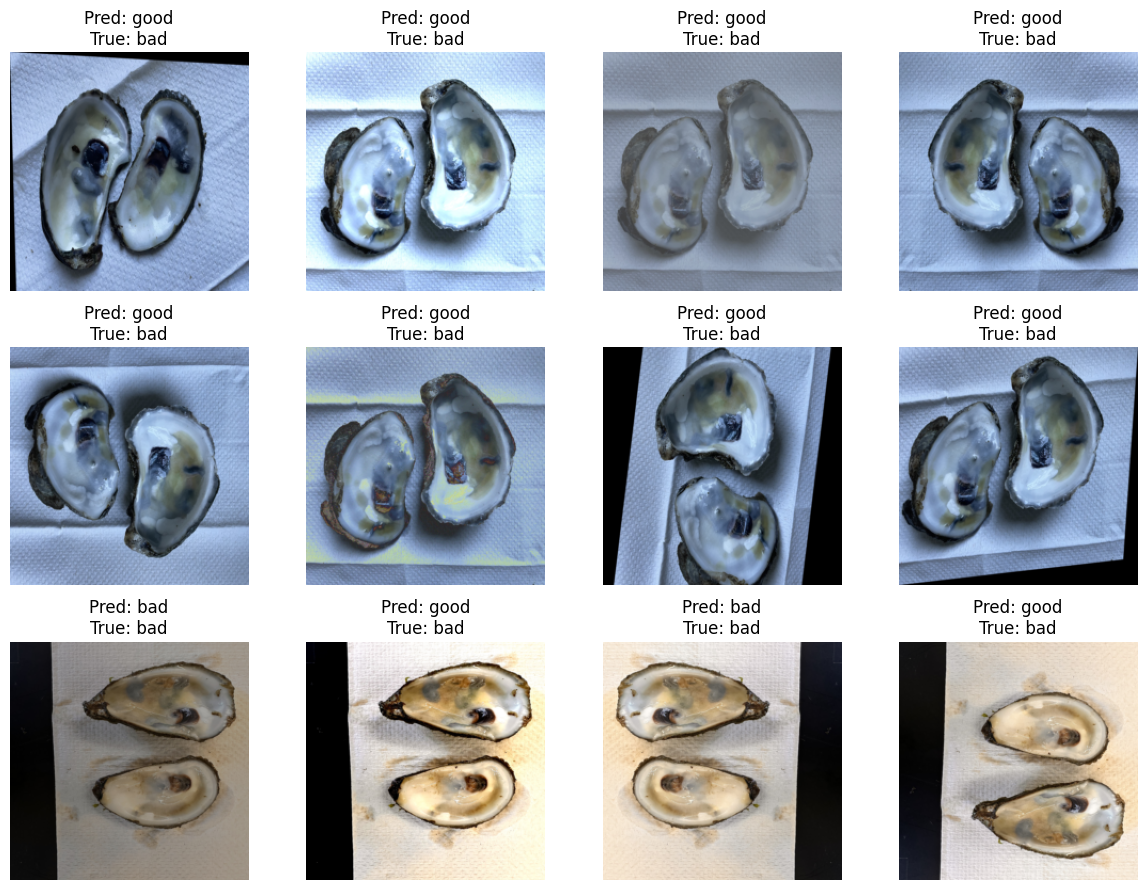

In [47]:
import matplotlib.pyplot as plt

# Get class names
class_names = test_data.classes  # ['bad', 'good']

# Show a few test predictions
model.eval()
fig, axs = plt.subplots(3, 4, figsize=(12, 9))  # 12 images

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).cpu().squeeze().long()
        images = images.cpu()
        
        for idx in range(min(len(images), 12)):
            row = idx // 4
            col = idx % 4
            img = images[idx] / 2 + 0.5  # unnormalize
            npimg = img.numpy().transpose((1, 2, 0))
            axs[row, col].imshow(npimg)
            axs[row, col].set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx].item()]}")
            axs[row, col].axis('off')
        break  # only show one batch

plt.tight_layout()
plt.show()


In [48]:
!pip install scikit-learn


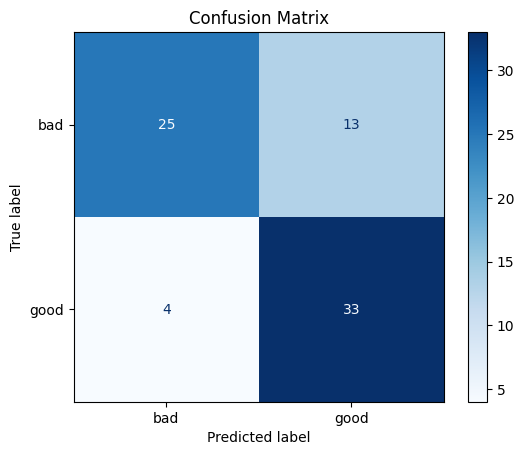

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Gather all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Convert to binary
all_preds = np.array(all_preds).astype(int).flatten()
all_labels = np.array(all_labels).astype(int).flatten()

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [51]:
import matplotlib.pyplot as plt

wrong_images = []
wrong_preds = []
wrong_labels = []

correct_images = []
correct_preds = []
correct_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).cpu()
        images = images.cpu()
        labels = labels.cpu()

        for i in range(len(images)):
            if preds[i] != labels[i]:
                wrong_images.append(images[i])
                wrong_preds.append(int(preds[i].item()))
                wrong_labels.append(int(labels[i].item()))
            else:
                correct_images.append(images[i])
                correct_preds.append(int(preds[i].item()))
                correct_labels.append(int(labels[i].item()))


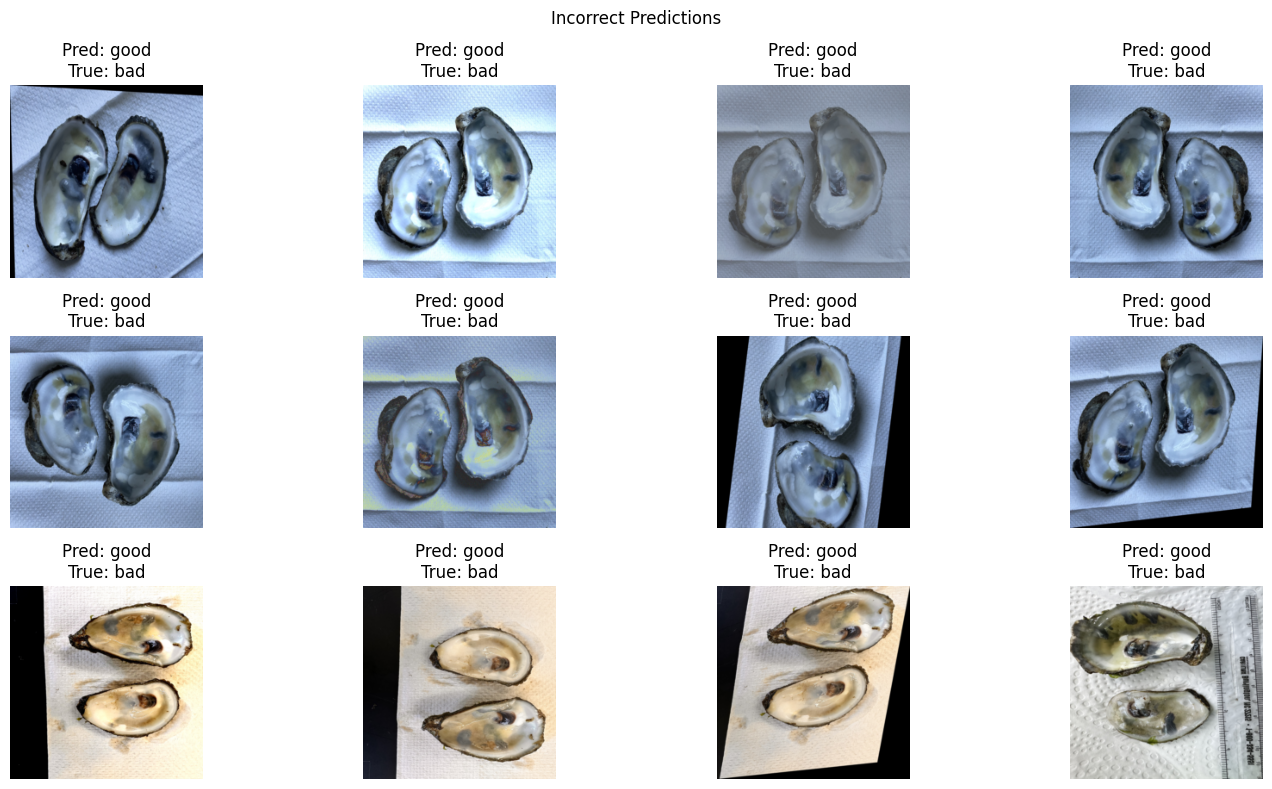

In [52]:
def show_predictions(images, preds, labels, title, class_names, max_display=12):
    plt.figure(figsize=(15, 8))
    for i in range(min(len(images), max_display)):
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy().transpose((1, 2, 0))
        plt.subplot(3, 4, i+1)
        plt.imshow(npimg)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Class names
class_names = test_data.classes

# Show wrong predictions
show_predictions(wrong_images, wrong_preds, wrong_labels, "Incorrect Predictions", class_names)


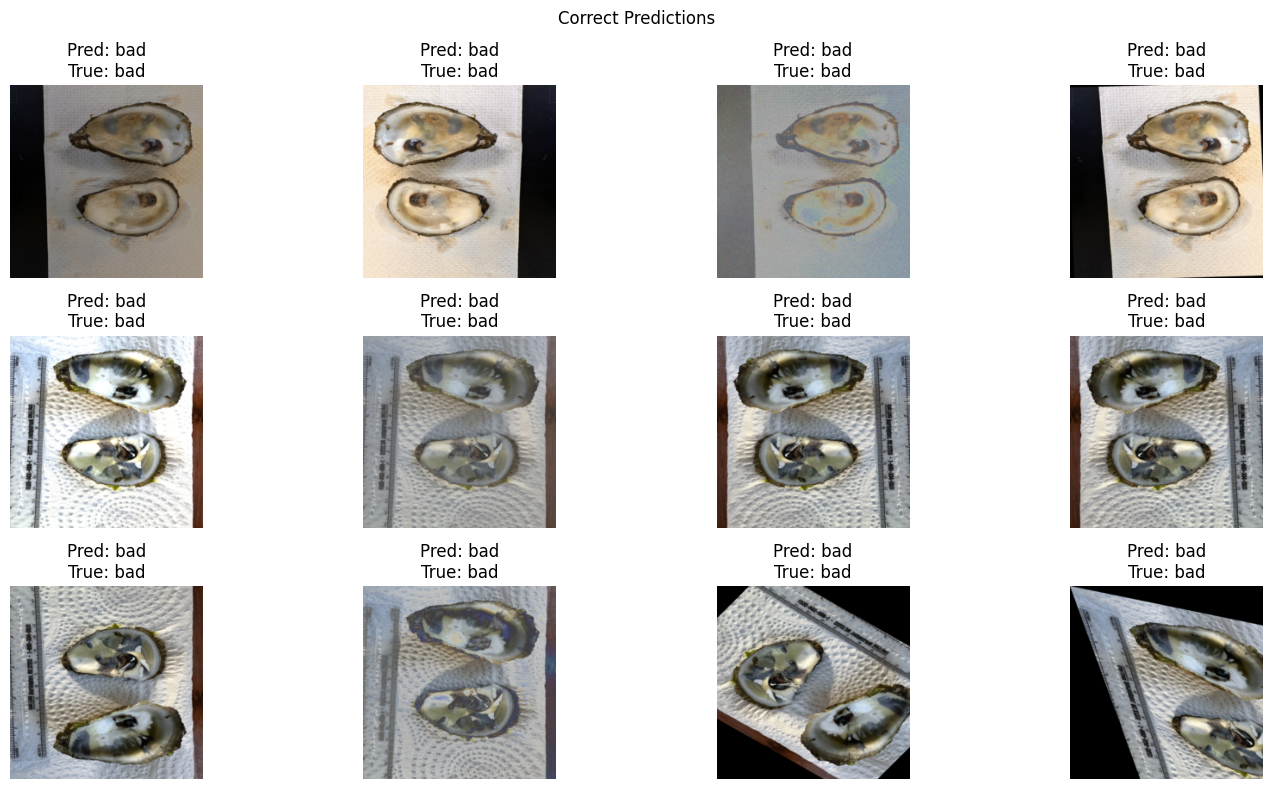

In [53]:
# Show correct predictions
show_predictions(correct_images, correct_preds, correct_labels, "Correct Predictions", class_names)


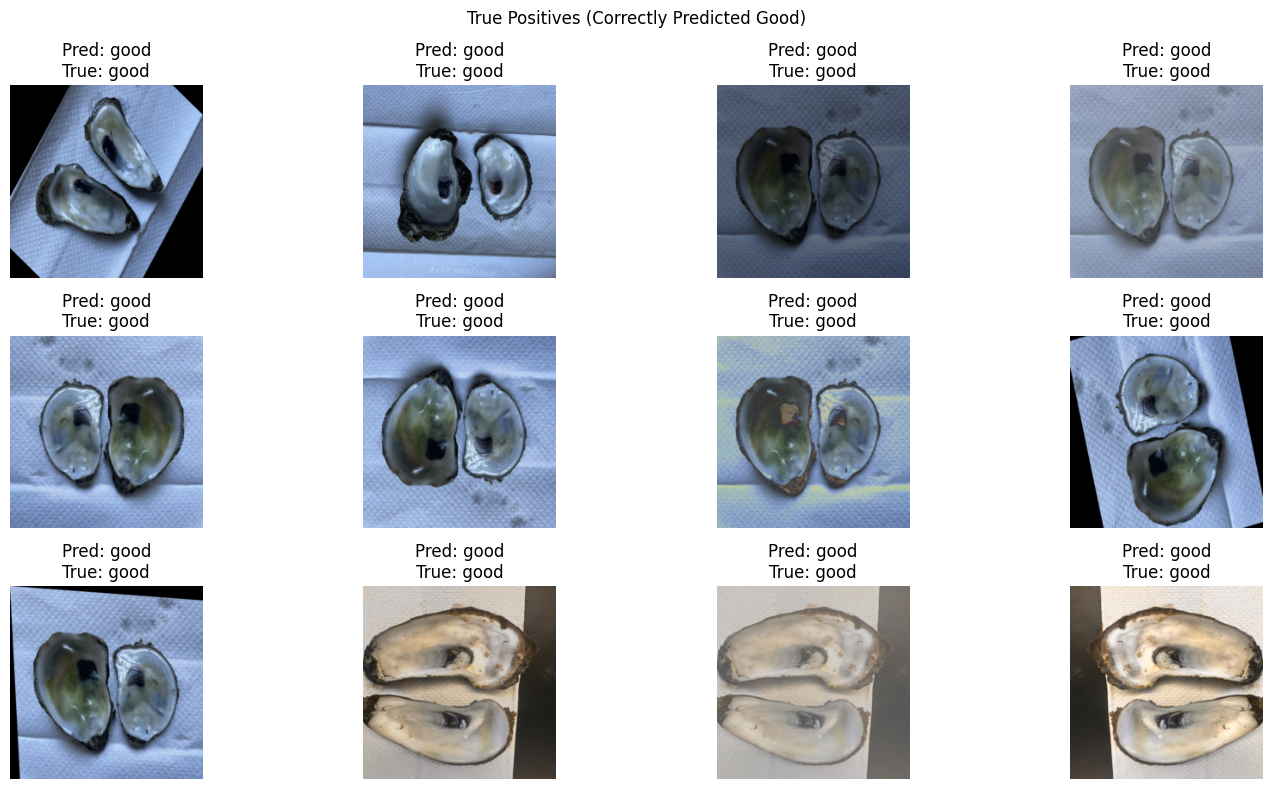

In [54]:
# Show only true positives: predicted = good (1) and label = good (1)
true_positive_images = []
true_positive_preds = []
true_positive_labels = []

for i in range(len(correct_images)):
    if correct_preds[i] == 1 and correct_labels[i] == 1:
        true_positive_images.append(correct_images[i])
        true_positive_preds.append(correct_preds[i])
        true_positive_labels.append(correct_labels[i])

# Visualize true positives
show_predictions(true_positive_images, true_positive_preds, true_positive_labels,
                 "True Positives (Correctly Predicted Good)", class_names)


In [55]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

         bad       0.86      0.66      0.75        38
        good       0.72      0.89      0.80        37

    accuracy                           0.77        75
   macro avg       0.79      0.77      0.77        75
weighted avg       0.79      0.77      0.77        75



##  Evaluation on Clean (Unaugmented) Test Set


In [77]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define the path to the cleaned dataset folder
clean_data_path = 'datasetOriginalTest'

# Use same transforms as before (resize, normalize — no augmentations)
clean_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load clean test dataset
clean_test_data = datasets.ImageFolder(os.path.join(clean_data_path, 'test'), transform=clean_test_transforms)
clean_test_loader = DataLoader(clean_test_data, batch_size=16, shuffle=False)

# Confirm classes and sample size
print("Clean Test Classes:", clean_test_data.classes)
print("Number of clean test images:", len(clean_test_data))


Clean Test Classes: ['bad', 'good']
Number of clean test images: 47


In [88]:
# Evaluate the model on clean (unaugmented) test images
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in clean_test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()
        total += labels.size(0)

clean_test_acc = correct / total * 100
print(f" Accuracy on Clean (Unaugmented) Test Set: {clean_test_acc:.2f}%")


 Accuracy on Clean (Unaugmented) Test Set: 78.72%


In [91]:
# Evaluate the model on clean (unaugmented) test images
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()
        total += labels.size(0)

clean_test_acc = correct / total * 100
print(f" Accuracy on Clean (Unaugmented) Test Set: {clean_test_acc:.2f}%")


 Accuracy on Clean (Unaugmented) Test Set: 77.33%


In [95]:
# Separate mistakes by type
false_positives = []
false_negatives = []

for i in range(len(wrong_images)):
    if wrong_preds[i] == 1 and wrong_labels[i] == 0:
        false_positives.append(wrong_images[i])
    elif wrong_preds[i] == 0 and wrong_labels[i] == 1:
        false_negatives.append(wrong_images[i])

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")


False Positives: 13
False Negatives: 4


## Visualize the 13 False Positives

In [117]:
print("Images:", len(false_positives))
print("Preds:", len([1]*len(false_positives)))
print("Labels:", len([0]*len(false_positives)))
print("Paths:", len(false_positive_paths))


Images: 26
Preds: 26
Labels: 26
Paths: 13


In [125]:
def show_predictions(images, preds, labels, title, class_names):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle(title, fontsize=16)

    for i in range(min(len(images), 12)):
        ax = axs[i // 4, i % 4]
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy().transpose((1, 2, 0))
        ax.imshow(npimg)
        ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


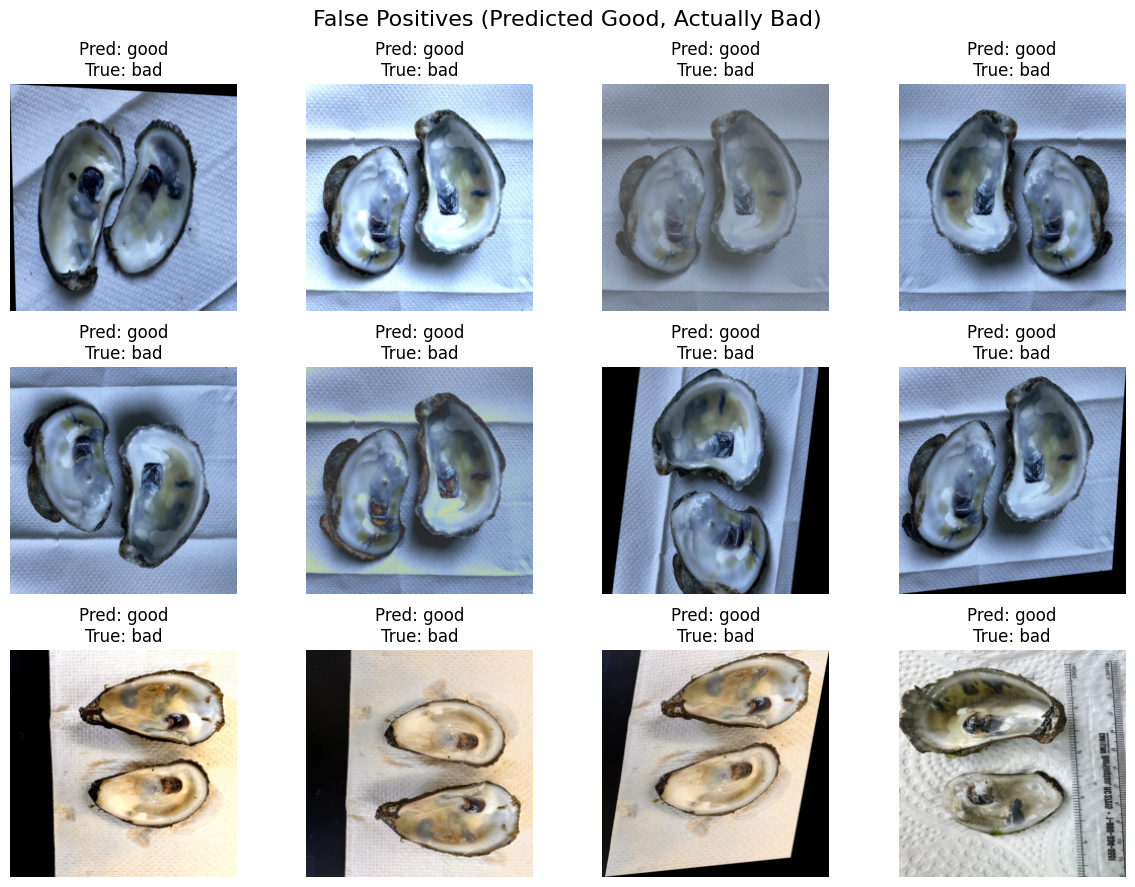

In [129]:
show_predictions(false_positives, [1]*len(false_positives), [0]*len(false_positives),
                 "False Positives (Predicted Good, Actually Bad)", class_names)


## Visualize the 4 False Negatives

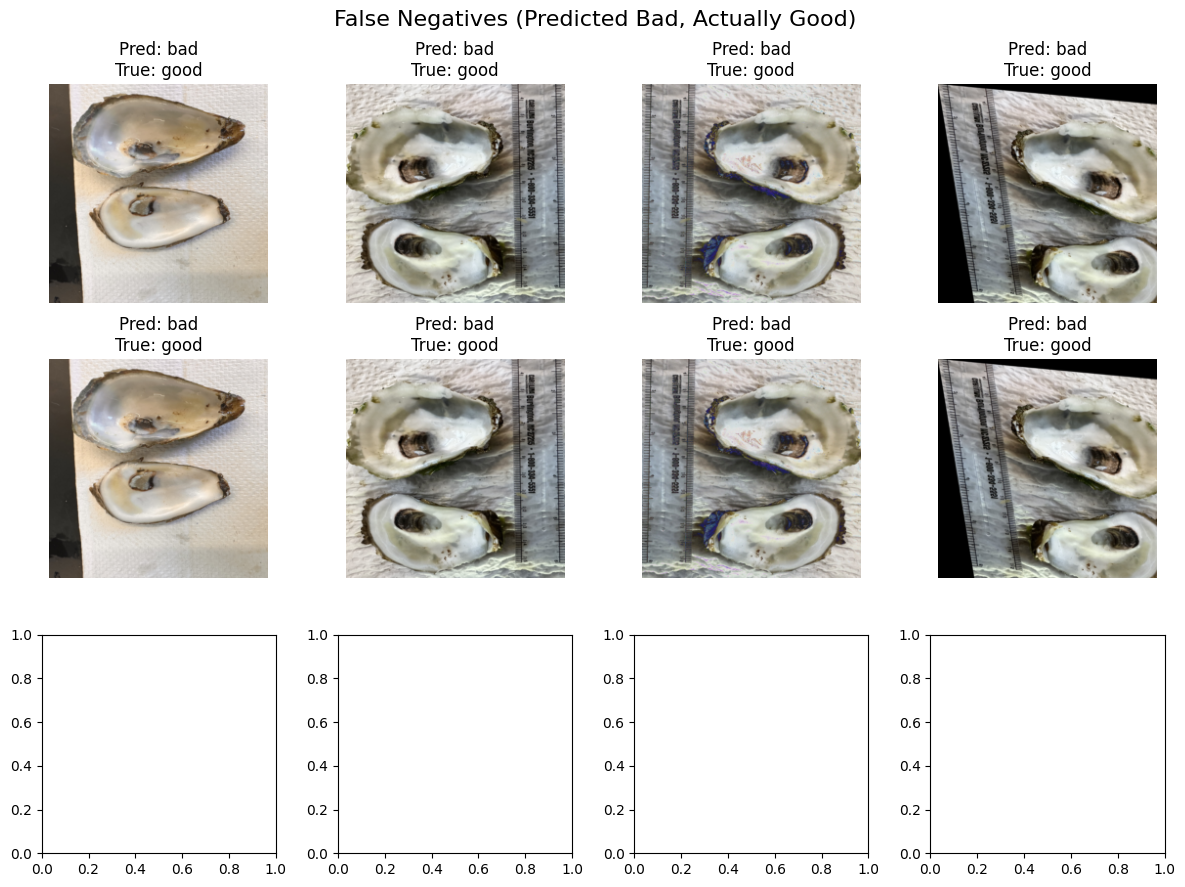

In [131]:
show_predictions(false_negatives, [0]*len(false_negatives), [1]*len(false_negatives),
                 "False Negatives (Predicted Bad, Actually Good)", class_names)


In [133]:
def average_brightness(img_tensor):
    return img_tensor.mean().item()

brightness_fp = [average_brightness(img) for img in false_positives]
brightness_fn = [average_brightness(img) for img in false_negatives]

print("Avg brightness - False Positives:", sum(brightness_fp) / len(brightness_fp))
print("Avg brightness - False Negatives:", sum(brightness_fn) / len(brightness_fn))


Avg brightness - False Positives: 0.10980436968832062
Avg brightness - False Negatives: 0.16039909061510116


In [135]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # optional
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [137]:
pip install torchcam


Note: you may need to restart the kernel to use updated packages.


In [141]:
print(model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [149]:
target_layer = model.features[18]



In [151]:
from torchcam.methods import GradCAM

cam_extractor = GradCAM(model, target_layer=target_layer)


In [153]:
# Step 1: Get target layer
target_layer = model.features[18]

# Step 2: Set up Grad-CAM
from torchcam.methods import GradCAM
cam_extractor = GradCAM(model, target_layer=target_layer)


In [169]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image

def show_gradcam(image_tensor, label):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    image_tensor.requires_grad_()  


    # Forward pass and get CAM
    scores = model(image_tensor)
    cam = cam_extractor(class_idx=int(label), scores=scores)[0].cpu()

    # Unnormalize image
    unnorm_img = image_tensor.squeeze().cpu() * 0.5 + 0.5  # assuming normalization to [-1, 1]
    np_img = unnorm_img.permute(1, 2, 0).detach().numpy()


    # Resize CAM to image
    cam = F.resize(cam.unsqueeze(0), size=[np_img.shape[0], np_img.shape[1]])[0].numpy()

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(np_img)
    ax.imshow(cam.squeeze(), cmap='jet', alpha=0.5)
    ax.set_title(f"Grad-CAM (Label: {label})")
    ax.axis('off')
    plt.show()


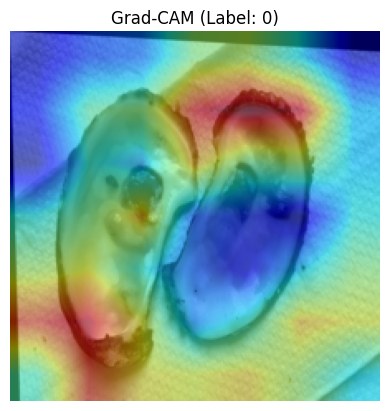

In [179]:
show_gradcam(false_positives[0], 0)

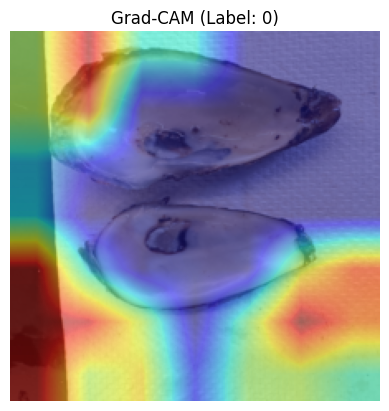

In [183]:
show_gradcam(false_negatives[0], 0)  # class 1 = good


In [254]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
# Standard ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("Dataset/train", transform=transform)
test_dataset = datasets.ImageFolder("Dataset/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes


In [256]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.last_channel, 1)  # Binary classification
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /Users/tusharkoushik/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 7.45MB/s]


In [258]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Test Accuracy: {acc:.2%}")
    model.train()

def train_model(model, train_loader, test_loader, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")
        evaluate(model, test_loader)


In [260]:
train_model(model, train_loader, test_loader, epochs=10)


Epoch 1/10 - Loss: 3.3012
Test Accuracy: 73.33%
Epoch 2/10 - Loss: 2.7528
Test Accuracy: 70.67%
Epoch 3/10 - Loss: 2.2212
Test Accuracy: 82.67%
Epoch 4/10 - Loss: 1.7567
Test Accuracy: 81.33%
Epoch 5/10 - Loss: 1.4798
Test Accuracy: 81.33%
Epoch 6/10 - Loss: 1.1199
Test Accuracy: 78.67%
Epoch 7/10 - Loss: 0.8826
Test Accuracy: 80.00%
Epoch 8/10 - Loss: 0.7926
Test Accuracy: 81.33%
Epoch 9/10 - Loss: 0.4914
Test Accuracy: 81.33%
Epoch 10/10 - Loss: 0.4529
Test Accuracy: 81.33%


In [262]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=class_names))


[[32  6]
 [ 8 29]]
              precision    recall  f1-score   support

         bad       0.80      0.84      0.82        38
        good       0.83      0.78      0.81        37

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75



In [264]:
# Freeze all except last classifier layer
for param in model.features.parameters():
    param.requires_grad = False


In [266]:
weights = torch.tensor([1.0, 1.0]).to(device)  # try adjusting if imbalance increases
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])


In [268]:
# Reinitialize optimizer to only update classifier parameters
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)
# Train using the new criterion and updated optimizer
train_model(model, train_loader, test_loader, epochs=5)


Epoch 1/5 - Loss: 0.3246
Test Accuracy: 82.67%
Epoch 2/5 - Loss: 0.2682
Test Accuracy: 84.00%
Epoch 3/5 - Loss: 0.4008
Test Accuracy: 84.00%
Epoch 4/5 - Loss: 0.2439
Test Accuracy: 84.00%
Epoch 5/5 - Loss: 0.2570
Test Accuracy: 84.00%
